In this notebook you'll find the scripts that builds three plots, that are used in the analysis.

Two plots relates to the Gini index feature. One plot relates to the R-squared values.


Script by Lars Kjær



# Gini index visualisation

This script in made to analyse results of the machine learning model and build two plots that deals with Gini index and square meter price. 

In [106]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [107]:
# Load parameter data
input_path = Path.cwd() / '../ml_data/fitted_models' # path of files to be found
parameter_data = pd.read_csv(input_path / 'coefficients_lasso.csv')

parameter = 'gini_index'
df_coefficients = parameter_data[parameter_data['parameter'] == parameter].iloc[:, [1,3]].rename(columns={'value':'gini_index'})

# Load municipality data
muni_codes = pd.read_csv('municipality_number_codes.csv', sep=';', names=['muni_name', 'muni_code'] )


# Merge the parameter and the geo data 
merged_df = muni_codes.merge(df_coefficients, on='muni_code')

# extract data for plot -- sum of municipalities Explanatory factor
gini_is_zero = len(merged_df[merged_df['gini_index'] == 0])
filtered_subset_gini_less_than_zero = len(merged_df[merged_df['gini_index'] < 0])
filtered_subset_gini_greater_than_zero = len(merged_df[merged_df['gini_index'] > 0])
gini_index_dist1 = pd.DataFrame({'Explanatory factor = zero.' : [gini_is_zero],
                                'Explanatory factor < zero.' : [filtered_subset_gini_less_than_zero],
                                'Explanatory factor > zero' : [filtered_subset_gini_greater_than_zero]})
gini_index_dist1 = gini_index_dist1.T.reset_index().rename(columns = {'index':'observations',
                                      0: 'sum'})


# extract data for plot - filtered_subset_gini_greater_than_zero
filtered_subset_gini_greater_than_zero = merged_df[merged_df['gini_index'] > 0]
filtered_subset_gini_greater_than_zero = filtered_subset_gini_greater_than_zero.sort_values('gini_index')

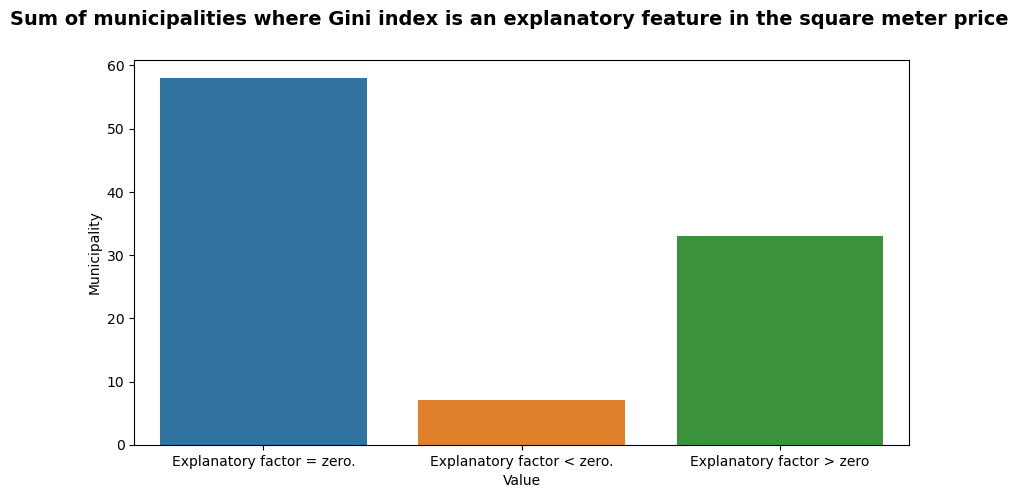

In [108]:
# Create a figure and subplots with two columns
fig, ax = plt.subplots(figsize=(10, 5))

# Create the bar plot using sns.barplot
ax = sns.barplot(x='observations', y='sum', data=gini_index_dist1)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Municipality')

# Title the figure
fig.suptitle('Sum of municipalities where Gini index is an explanatory feature in the square meter price', fontsize=14, fontweight='bold');

# Adjust layout
#plt.tight_layout()

# Show the plots
plt.show()

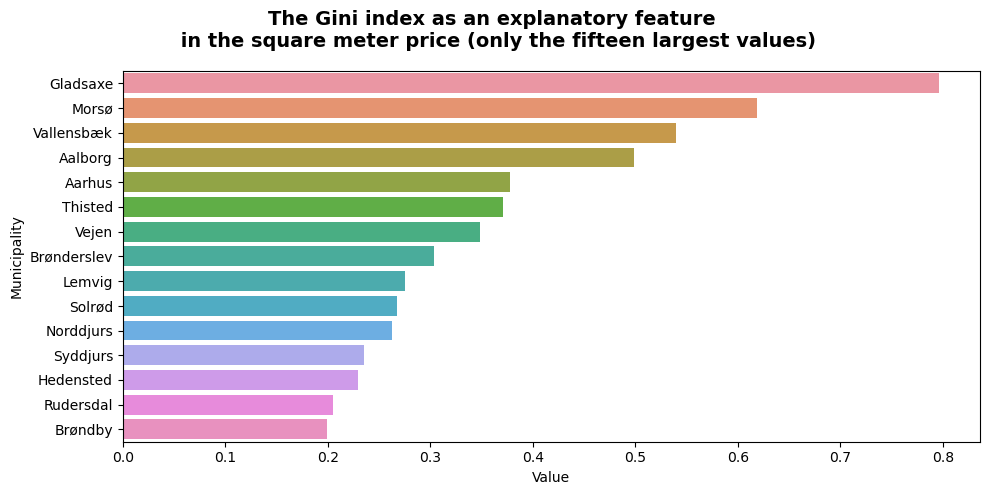

In [109]:
# Create a figure and subplots with two columns
fig, ax = plt.subplots(figsize=(10, 5))

# Create the bar plot using sns.barplot
ax = sns.barplot(x='gini_index', y='muni_name', data=filtered_subset_gini_greater_than_zero.sort_values('gini_index',
                                                                                                       ascending=False).head(15))

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Municipality')

# Title the figure
fig.suptitle('The Gini index as an explanatory feature \n in the square meter price (only the fifteen largest values)', fontsize=14, fontweight='bold');

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

# Plot of R-squared value in relation to sum of sale, and quartiles

This plot illustrates Relationship between R-squared values, their corresponding quartiles, and the sum of sales across municipalities.

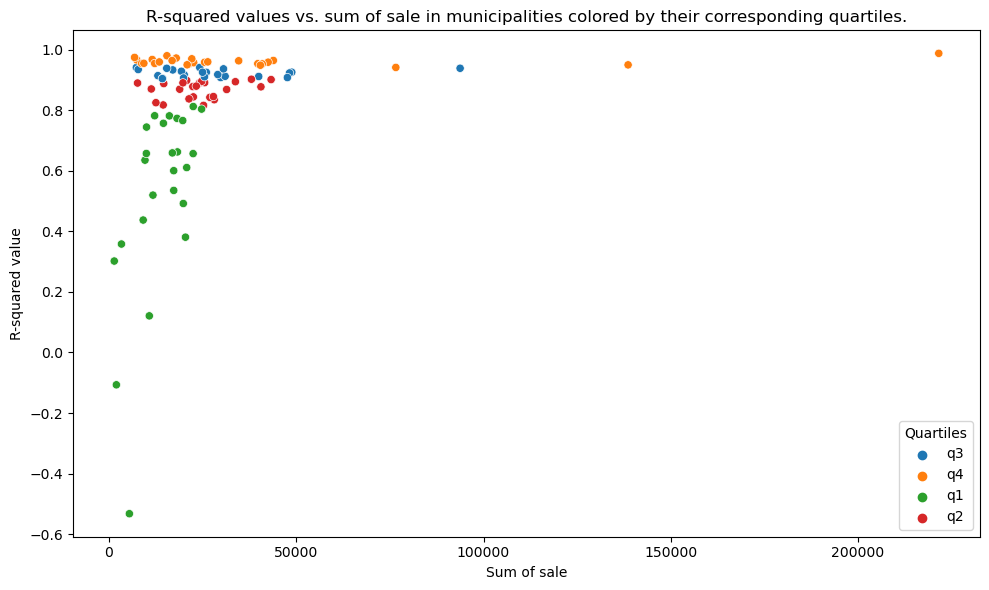

In [110]:
from pathlib import Path
import os
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load parameter data
input_path = Path.cwd() / 'ml_data/fitted_models' # path of files to be found
parameter_data = pd.read_csv(input_path / 'metrics_lasso.csv')


# Load municipality data
muni_codes = pd.read_csv('municipality_number_codes.csv', sep=';', names=['muni_name', 'muni_code'] )

# Merge the parameter and the geo data 

merged_df = muni_codes.merge(parameter_data, on='muni_code')
merged_df = merged_df.loc[:, ['muni_code', 'muni_name', 'rmse', 'r2']]


# get data on numbers of sales 
inlier_data_path = Path.cwd() / 'Boliga data/inlier_data/'
files = os.listdir(inlier_data_path)
dfs =  []
for i in files:
    df = pd.read_csv(inlier_data_path/i, low_memory=False)
    dfs.append(df)
    
    
# concat dataframes, wrangle, send back to new dataframe, and merge into 'merged_df' 
new_df = pd.concat(dfs)
new_df = new_df['municipality'].value_counts().to_frame().reset_index().rename(columns = {'index' : 'muni_code', 'municipality': 'sum_sale'})

merged_df = merged_df.merge(new_df, on='muni_code', how='left')

# Calculate summary statistics using describe()
summary_stats = merged_df['r2'].describe()

# Extract quartile values from the summary statistics
q1 = summary_stats['25%']
q2 = summary_stats['50%']
q3 = summary_stats['75%']

# Create a function to assign quartile labels
def assign_quartile(value):
    if value <= q1:
        return 'q1'
    elif value <= q2:
        return 'q2'
    elif value <= q3:
        return 'q3'
    else:
        return 'q4'

# Add quartile labels column to the DataFrame
merged_df['quartiles'] = merged_df['r2'].apply(assign_quartile)

# sort value 'r2'
sort_merged_data = merged_df.sort_values('r2').reset_index(drop=True)

# subset q4 
sort_merged_data_q4 = sort_merged_data[sort_merged_data['quartiles'] == 'q4']

#sort_merged_data_q4.sort_values('r2', ascending=False).head(10) 

# Create a scatter plot
plt.figure(figsize=(10, 6))  # Set the figure size

sns.scatterplot(data = merged_df, x='sum_sale', y='r2', hue='quartiles')

# Customize title and labels
plt.title("R-squared values vs. sum of sale in municipalities colored by their corresponding quartiles.")
plt.xlabel('Sum of sale')
plt.ylabel('R-squared value')


# Move the legend
order = []
plt.legend(title='Quartiles', loc='lower right')

# Show the plot
plt.tight_layout()
plt.show()